# The HFM library - A fast marching solver with adaptive stencils

## Part : Applications
## Chapter : Optimal routing of a boat

In this notebook, we compute the optimal route for a boat under the following assumptions:
- The objective is to minimize a weighted sum of the fuel consumption and of the travel time.
- The boat fuel consumption is locally a quadratic function of its relative velocity, w.r.t. water.
- The boat total velocity is the sum of the relative velocity w.r.t water and of a drift due to water currents.
- The problem data, including water currents, does not depend on time (but may depend on space).

**Discussion of the assumptions**

These assumptions chosen above are a strong simplification of reality. Some of them may be relaxed, at the price of more complexity in the implementation. 
- Often the objective is to minimize fuel consumption subject to a constraint on the arrival date. This problem is equivalent to the weighted objective problem, for a suitable value of the weights, which can be obtained by dichotomy.
- The boat velocity model can be complexified. Any convex cost, approximated in a suitable manner, can be handled by our numerical methods. However, determining this cost (which depends on the physical properties of the boat), and approximating it (fitting a convex set with an intersection of ellipsoids), may raise difficulties in itself. In addition, the assumption of local controllability is required for the methods described in this notebook: the boat can navigate anywhere and in any direction in water, for a sufficiently high fuel consumption.
- The problem, such as the meteorological conditions, may be time dependent. In that case, a completely different set of numerical methods is needed, described in another notebook.
- The boat state may include variables additional to position. For instance velocity if the boat has inertia, or the current state of the sails if any.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [9]:
import sys; sys.path.insert(0,"../..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('BoatRouting','FMM'))

In [191]:
from agd import HFMUtils
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd.Metrics import Rander,Riemann
from agd import AutomaticDifferentiation as ad
from agd.Plotting import savefig; #savefig.dirName = 'Images/BoatRouting'

In [13]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Utility functions

In [49]:
norm_infinity = ad.Optimization.norm_infinity
from agd.ExportedCode.Notebooks_NonDiv.LinearMonotoneSchemes2D import streamplot_ij

def quiver(X,Y,U,V,subsampling=1,**kwargs):
    def f(Z): return Z[::subsampling,::subsampling]
    plt.quiver(f(X),f(Y),f(U),f(V),**kwargs)

In [83]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,lp,fd,Rander,ad
    HFMUtils,lp,fd,Rander,ad = rreload([HFMUtils,lp,fd,Rander,ad],"../..")

## 1. Constant medium

We assume in this section that the problem geometry $M$, and the water currents $\omega$, are independent of space (in addition to time). The third important problem constant is the weight $\alpha>0$ of the travel-time in the objective.

Assume that the boat travels for some time $t$, with instantaneous fuel consumption $\rho$, and with constant unit direction $u$, which is are unknowns of the problem. By our assumptions, the boat reaches the point 
$$
    v = (u\sqrt \rho + \omega) t, 
$$
and one has $\|u\|_M = 1$. In the next section, the positive definite matrix $M$ will be used to describe the earth geometry. The cost of this particular travel is 
$$
    (\rho+\alpha) t,
$$
which is the sum of the total fuel consumption $\rho t$, and the travel time $t$ weighted by $\alpha$.

Minimizing over $t,\rho,u$, subject to the constraint that the endpoint $v$ is met, a simple analysis yields that the cost of this travel is $2 N_\alpha(v)$ where
$$
    N_\alpha(v) := \|v\|_M \sqrt{ \|\omega\|_M^2+\alpha} - <v,\omega>_M.
$$
The optimal parameters $(t_{\min},\rho_{\min},u_{\min})$ are characterized by 
$$
    t_{\min} = \frac {\|v\|_M} {\sqrt{\|\omega\|_M^2 +\alpha}},
$$
from which one easily deduces $\rho_{\min}$ and $u_{\min}$.

In [29]:
def route_min(v,params):
    v,α,ω,M = fd.common_field((v,)+params,depths=(1,0,1,2))
    v_norm = np.sqrt(lp.dot_VAV(v,M,v))
    ωα_norm = np.sqrt( lp.dot_VAV(ω,M,ω) + α)
    cost = 2*(v_norm*ωα_norm - lp.dot_VAV(v,M,ω))
    time = v_norm / ωα_norm
    fuel = cost/time - α
    head = (v/time - ω)/np.sqrt(fuel)
    return {
        'cost':cost,
        'time':time,
        'fuel':fuel, # ρ, instantaneous fuel consumption
        'head':head, # u, where to head for
    }

In [80]:
def metric(params):
    α,ω,M = fd.common_field(params,depths=(0,1,2))
    return Rander( M*(lp.dot_VAV(ω,M,ω) + α), -lp.dot_AV(M,ω)).with_cost(2.)

In [81]:
# Generate a cartesian grid
aX = np.linspace(-1,1)
X = np.array(np.meshgrid(aX,aX,indexing='ij'))

The following observations can be made.
- It is cheaper to travel in the direction of the water currents. (As expected.)
- The travel time is symmetric w.r.t. $v$. This was expected in view of the above formula, but it is nonetheless surprising.
- The instantaneous fuel consumption only depends on the direction, not the travel time. It is stronger when one goes against the water currents. (As expected for a time independent problem.)
- The boat does not head straight where it needs to go, moves like a crab, taking avantage (or fighting against) water currents.

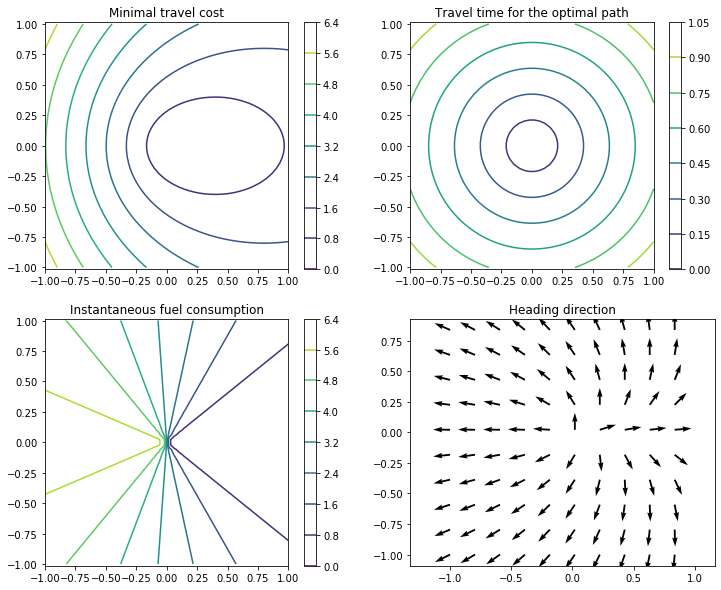

In [88]:
# Parameters : unit weight for time, unit horizontal drift, euclidean geometry
params = (1.,np.array((1.,0.)),np.eye(2))
route = route_min(X,params)
assert np.allclose(metric(params).norm(X),route['cost'])

plt.figure(figsize=[12,10])

plt.subplot(2,2,1); plt.axis('equal')
plt.title('Minimal travel cost')
plt.contour(*X,route['cost']); plt.colorbar()

plt.subplot(2,2,2); plt.axis('equal')
plt.title('Travel time for the optimal path')
plt.contour(*X,route['time']); plt.colorbar()

plt.subplot(2,2,3); plt.axis('equal')
plt.title('Instantaneous fuel consumption')
plt.contour(*X,route['fuel']); plt.colorbar()

plt.subplot(2,2,4); plt.axis('equal')
plt.title('Heading direction')
quiver(*X,*route['head'],subsampling=5)

By setting $\alpha=0$, we do not penalize travel time. In that case:
- the minimal travel cost vanishes in the direction of the drift.
- the travel time increases, but not indefinitely. Indeed, excessively long paths would use more fuel in total.

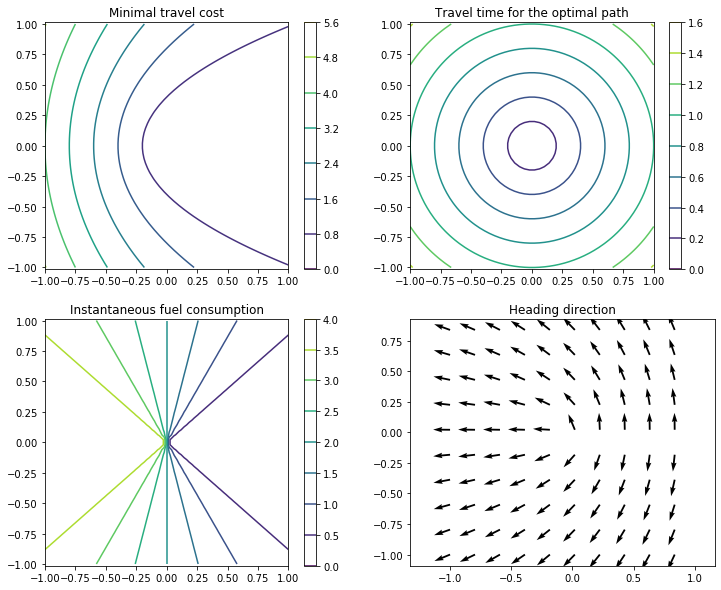

In [67]:
# Parameters : unit weight for time, unit horizontal drift, euclidean geometry
params = (0.,np.array((1.,0.)),np.eye(2))
route = route_min(X,params)

plt.figure(figsize=[12,10])

plt.subplot(2,2,1); plt.axis('equal')
plt.title('Minimal travel cost')
plt.contour(*X,route['cost']); plt.colorbar()

plt.subplot(2,2,2); plt.axis('equal')
plt.title('Travel time for the optimal path')
plt.contour(*X,route['time']); plt.colorbar()

plt.subplot(2,2,3); plt.axis('equal')
plt.title('Instantaneous fuel consumption')
plt.contour(*X,route['fuel']); plt.colorbar()

plt.subplot(2,2,4); plt.axis('equal')
plt.title('Heading direction')
quiver(*X,*route['head'],subsampling=5)

By setting $\alpha$ to a large value, we strongly penalize travel time. In that case:
- the minimal travel cost is almost isotropic. Indeed, the boat must go fast, to reduce travel time, hence the drift becomes negligible.
- the instantaneous fuel consumption is almost independent of the direction, and the boat heads straight where it needs to go. Again, this is because the boat goes fast, so that drift is negligible.

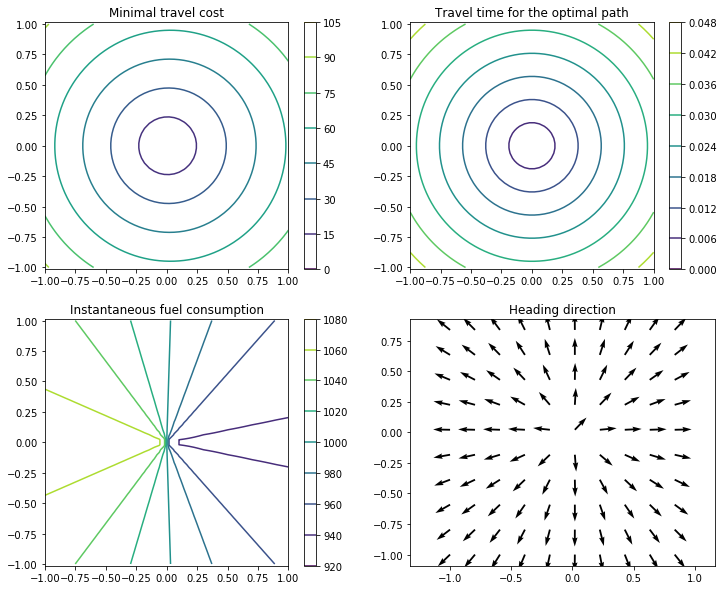

In [59]:
# Parameters : unit weight for time, unit horizontal drift, euclidean geometry
params = (1e3,np.array((1.,0.)),np.eye(2))
route = route_min(X,params)

plt.figure(figsize=[12,10])

plt.subplot(2,2,1); plt.axis('equal')
plt.title('Minimal travel cost')
plt.contour(*X,route['cost']); plt.colorbar()

plt.subplot(2,2,2); plt.axis('equal')
plt.title('Travel time for the optimal path')
plt.contour(*X,route['time']); plt.colorbar()

plt.subplot(2,2,3); plt.axis('equal')
plt.title('Instantaneous fuel consumption')
plt.contour(*X,route['fuel']); plt.colorbar()

plt.subplot(2,2,4); plt.axis('equal')
plt.title('Heading direction')
quiver(*X,*route['head'],subsampling=5)

## 2. Space-varying medium

In this section, we considere a setup with space dependent geometry, water currents, and obstacles.
Finding the optimal route requires solving an eikonal equation, which we do using the HFM library.

The first step is to define the location of the obstacles, the starting point, and the target points.

In [161]:
hfmIn = HFMUtils.dictIn({
    'model':'Rander2', # Riemannian + drift, what is needed here
    'exportValues':1,
    'exportGeodesicFlow':1,
    'seeds':[[-1.7,0.6]], # Where to start the front propagation
})
hfmIn.SetRect([[-2,2],[-1,1]],dimx=200) # Rectangular domain
X = hfmIn.Grid() # Coordinate system
hfmIn.update({
    'tips':hfmIn.Grid(dims=(6,3)).reshape(2,-1).T, # Points from which to backtrack geodesics
    'walls':X[1]-np.abs(X[0])>=0, # Obstacles in the domain
})

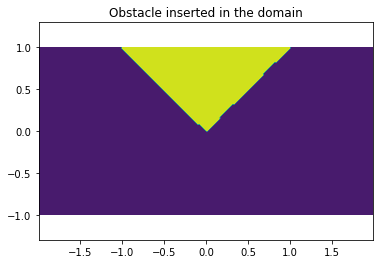

In [162]:
plt.title('Obstacle inserted in the domain'); plt.axis('equal')
plt.contourf(*X, hfmIn['walls']);

We now define the Riemannian metric $M$. Here, we choose the metric attached to a sphere, a.k.a. the earth, of radius one. Recall that the intrinsic metric on a manifold embedded in Euclidean space is 
$$
    M(x) = df(x)^T df(x) = \nabla f(x) \nabla f(x)^T,
$$
where $df$ is the differential of $f$, and $\nabla f(x) = df(x)^T$. 

In [163]:
def Spherical(θ,ϕ): 
    """Spherical embedding: θ is longitude, ϕ is latitude from equator toward pole"""
    return (np.cos(θ)*np.cos(ϕ), np.sin(θ)*np.cos(ϕ), np.sin(ϕ))
    
X_ad = ad.Dense.identity(constant=X,shape_free=(2,)) # First order dense AD variable
Embed_ad = Spherical(*X_ad) # Differentiate the spherical embedding
Embed_grad = ad.asarray(Embed_ad).gradient()
Embed_M = lp.dot_AA(Embed_grad,lp.transpose(Embed_grad)) # Riemannian metric

We now choose the water (surface) currents, arbitrarily. They are defined in the local chart $\theta,\phi$, and not on the three dimensional sphere, for simplicity.

In [164]:
def bump(x,y): 
    """Gaussian-like bump (not normalized)"""
    return np.exp(-(x**2+y**2)/2)

def Currents(θ,ϕ):
    """Some arbitrary vector field (water currents)"""
    bump0 = bump(θ+1,(ϕ+0.3)*2); ω0=(0,1) # intensity and direction of the currents
    bump1 = 2*bump(2*(θ-0.7),ϕ-0.2); ω1=(1,-1)
    bump0,ω0,bump1,ω1 = fd.common_field( (bump0,ω0,bump1,ω1), depths=(0,1,0,1))
    return bump0*ω0+bump1*ω1

Embed_ω = Currents(*X)

We have put two strong currents:
- One in the west, towards north. One can however get around it, east or west.
- One in east, towards south-east. One cannot get around this one, but it is nevertheless weaker in the south than the north.

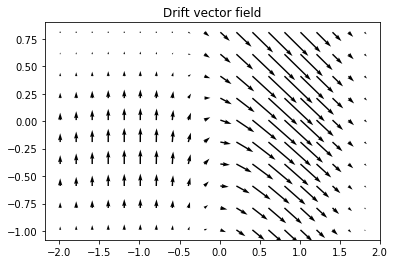

In [165]:
plt.title('Drift vector field')
quiver(*X,*Embed_ω,subsampling=10)

In [188]:
params = (1.,Embed_ω,Embed_M) # Weight α = 1 for time w.r.t fuel
hfmIn['metric'] = metric(params) 

It is worth noting that the problem metric is quite strongly anisotropic, due to the presence of strong currents. Recall that the anisotropy, at a given point, is the maximum ratio of the travel cost from that point in two different directions of unit Euclidean norm. A.k.a it is much cheaper to be pushed by the current than to go against it.

In [197]:
np.max(hfmIn['metric'].anisotropy_bound()) # only an upper bound

31.951100165730725

The problem is already anisotropic (but not asymmetric) without the currents, due to the geometry of the sphere. However, that anisotropy is much less pronounced.

In [195]:
np.max(Riemann(Embed_M).anisotropy()) 

1.8225231990619313

In [167]:
hfmOut = hfmIn.RunSmart()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.362727 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


Some observations : 
- On the west, one sees as expected that the optimal paths get around the strong current by both sides. This creates a non-differentiability in the value function.
- On the east, the south-east current is very strong. The minimal paths which need to go north follow the current it until they can get out of it, at $\theta\approx 1.5$, and then they change direction.

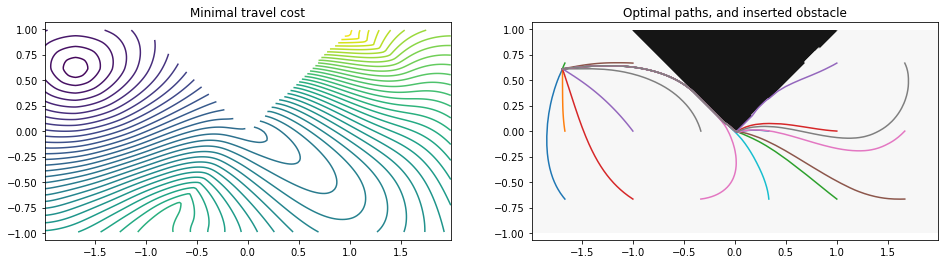

In [181]:
plt.figure(figsize=[16,4])

plt.subplot(1,2,1); plt.axis('equal')
plt.title('Minimal travel cost')
plt.contour(*X,hfmOut['values'],levels=50)

plt.subplot(1,2,2); plt.axis('equal')
plt.title('Optimal paths, and inserted obstacle')
plt.contourf(*X,hfmIn['walls'],cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(*geo)

The HFM library exports the geodesic flow, which is the local direction of the minimal geodesics from the seed point. Using this quantity we can recover the instantaneous fuel consumption, and the direction toward which the boat is headed. One observes that:
- the fuel consumption is highest when the boat needs to go against water currents.
- in the west the boat direction is almost opposite to the current (face current), whereas in the east the boat direction is often almost othogonal to the current (back current).

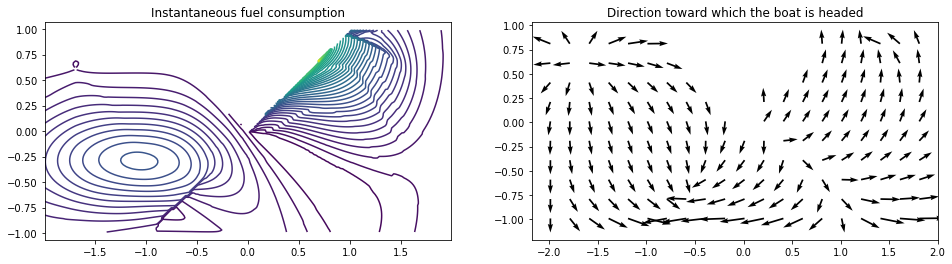

In [183]:
v = hfmOut['flow']
v[:,ad.Optimization.norm(v,axis=0)==0] = np.nan # Avoid division by zero where there is no velocity (walls, seed)
route = route_min(v,params)

plt.figure(figsize=[16,4])

plt.subplot(1,2,1); plt.axis('equal')
plt.title('Instantaneous fuel consumption')
plt.contour(*X,route['fuel'],levels=50)

plt.subplot(1,2,2); plt.axis('equal')
plt.title('Direction toward which the boat is headed')
quiver(*X,*route['head'],subsampling=10)

One may also recover the total fuel consumption, and the total travel time, integrated along the geodesics, by solving one additional first order PDE. 

### 2.1 Variants

We can increase the cost of time. As before, if we increase it a lot, then the drift due to water currents becomes negligible.

In [211]:
params = (1e3,Embed_ω,Embed_M) # Weight α = 1 for time w.r.t fuel
hfmIn['metric'] = metric(params) 
hfmOut = hfmIn.RunSmart()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.285565 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


In the limit, as $\alpha \to \infty$, the geodesics coincide with the great circles on the sphere - except when they hit the obstacles or the domain boundary.

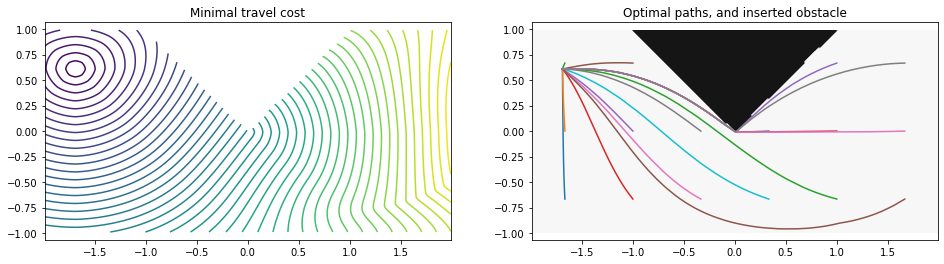

In [212]:
plt.figure(figsize=[16,4])

plt.subplot(1,2,1); plt.axis('equal')
plt.title('Minimal travel cost')
plt.contour(*X,hfmOut['values'],levels=50)

plt.subplot(1,2,2); plt.axis('equal')
plt.title('Optimal paths, and inserted obstacle')
plt.contourf(*X,hfmIn['walls'],cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(*geo)

The fuel consumption varies much less, and the boat heads directly where it needs to go.

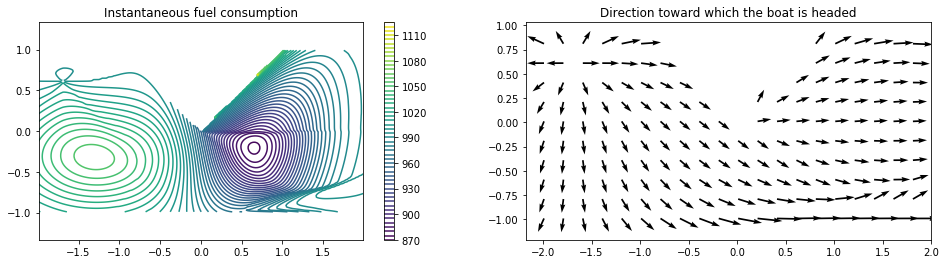

In [214]:
v = hfmOut['flow']
v[:,ad.Optimization.norm(v,axis=0)==0] = np.nan # Avoid division by zero where there is no velocity (walls, seed)
route = route_min(v,params)

plt.figure(figsize=[16,4])

plt.subplot(1,2,1); plt.axis('equal')
plt.title('Instantaneous fuel consumption')
plt.contour(*X,route['fuel'],levels=50); plt.colorbar()

plt.subplot(1,2,2); plt.axis('equal')
plt.title('Direction toward which the boat is headed')
quiver(*X,*route['head'],subsampling=10)

In one removes the drift (equivalently $\alpha \to \infty$), the instantaneous fuel consumption becomes constant along the journey, which is expected.

In [216]:
params = (1.,(0,0),Embed_M) # Weight α = 1 for time w.r.t fuel
hfmIn['metric'] = metric(params) 
hfmOut = hfmIn.RunSmart()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.290142 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


In [217]:
v = hfmOut['flow']
v[:,ad.Optimization.norm(v,axis=0)==0] = np.nan # Avoid division by zero where there is no velocity (walls, seed)
route = route_min(v,params)

print("Extremes of fuel instantaneous consumption : min", np.nanmin(route['fuel']), np.nanmax(route['fuel']))

Extremes of fuel instantaneous consumption : min 1.0 1.0
